In [7]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from typing import List, Dict
# 20 sec

In [8]:
import this

In [9]:
from concurrent.futures import ThreadPoolExecutor

In [10]:
import sqlite3 as sql
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
# import pytorch_lightning as pl
from pytorch_lightning import Trainer, LightningDataModule, LightningModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# fails after 1min 10 sec and reruns within 10 sec

In [12]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [13]:
NuE_PeV_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22015/"
NuMu_PeV_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22012/"
NuTau_PeV_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22018/"

truth_NuE_PeV_1 = NuE_PeV_root + "truth_1.parquet"
truth_NuMu_PeV_1 = NuMu_PeV_root + "truth_1.parquet"
truth_NuTau_PeV_1 = NuTau_PeV_root + "truth_1.parquet"

PMTfied_NuE_PeV_1 = NuE_PeV_root + "1/"
PMTfied_NuE_PeV_1_1 = PMTfied_NuE_PeV_1 + "PMTfied_1.parquet"

PMTfied_NuMu_PeV_1 = NuMu_PeV_root + "1/"
PMTfied_NuMu_PeV_1_1 = PMTfied_NuMu_PeV_1 + "PMTfied_1.parquet"

PMTfied_NuTau_PeV_1 = NuTau_PeV_root + "1/"
PMTfied_NuTau_PeV_1_1 = PMTfied_NuTau_PeV_1 + "PMTfied_1.parquet"

In [14]:
PMTfied_NuE_PeV_1_1

'/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/22015/1/PMTfied_1.parquet'

In [15]:
def get_files_in_dir(directory, extension='.parquet'):
    return [f for f in os.listdir(directory) if f.endswith(extension)]
def get_subdir_in_dir(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

In [16]:
get_subdir_in_dir(NuE_PeV_root)

['4', '11', '9', '3', '7', '12', '2', '8', '5', '10', '1', '6']

In [17]:
def convertParquetToDF(file:str) -> pd.DataFrame:
    table = pq.read_table(file)
    df = table.to_pandas()
    return df

In [22]:
df_PMTfied_NuE_PeV_1_1 = convertParquetToDF(PMTfied_NuE_PeV_1_1)
# 16 sec
# 695403 rows × 24 columns

In [23]:
def isClean(df:pd.DataFrame) -> bool:
    return not df.isna().any().any()

In [25]:
print(isClean(df_PMTfied_NuE_PeV_1_1))

True


In [26]:
class PostPreProcessor:
    def __init__(self):
        self.position_scaler = 2e-3  # 1/500
        self.t_scaler = 3e-4         # 1/30000
        self.t_shifter = 1e4         # (-) 10000
        self.Q_shifter = 2           # (-) 2 in log10

    def __call__(self, file: str) -> pa.Table:
        return self._pseudo_normalise_file(file)

    def _pseudo_normalise_file(self, file: str) -> pa.Table:
        table = self._read_parquet(file)
        table = self._log10_charge(table)
        table = self._pseudo_normalise_dom_pos(table)
        table = self._pseudo_normalise_time(table)
        return table

    def _read_parquet(self, file: str) -> pa.Table:
        return pq.read_table(file)

    def _log10_charge(self, table: pa.Table) -> pa.Table:
        q_columns = ['q1', 'q2', 'q3', 'q4', 'q5', 'Q25', 'Q75', 'Qtotal']
        for col in q_columns:
            if col in table.column_names:
                col_array = table[col].to_pandas()
                new_col = np.where(col_array > 0, np.log10(col_array), 0) - self.Q_shifter
                # Replace the column
                idx = table.column_names.index(col)
                table = table.set_column(idx, col, pa.array(new_col))
        return table

    def _pseudo_normalise_dom_pos(self, table: pa.Table) -> pa.Table:
        pos_columns = ['dom_x', 'dom_y', 'dom_z', 'dom_x_rel', 'dom_y_rel', 'dom_z_rel']
        for col in pos_columns:
            if col in table.column_names:
                new_col = table[col].to_pandas() * self.position_scaler
                # Replace the column
                idx = table.column_names.index(col)
                table = table.set_column(idx, col, pa.array(new_col))
        return table

    def _pseudo_normalise_time(self, table: pa.Table) -> pa.Table:
        t_columns = ['t1', 't2', 't3', 'T10', 'T50', 'sigmaT']
        t_columns_shift = ['t1', 't2', 't3']

        # Time shifting
        for col in t_columns_shift:
            if col in table.column_names:
                shifted = table[col].to_pandas() - self.t_shifter
                idx = table.column_names.index(col)
                table = table.set_column(idx, col, pa.array(shifted))

        # Time scaling
        for col in t_columns:
            if col in table.column_names:
                scaled = table[col].to_pandas() * self.t_scaler
                idx = table.column_names.index(col)
                table = table.set_column(idx, col, pa.array(scaled))

        return table


In [42]:
class PMTfiedDataset_part(Dataset):
    PSEUDO_NORMALISER = PostPreProcessor()
    """
    This dataset corresponds to a PMTfied pulsemap data from a single .db file.
    e.g., merged_part_1.db, merged_part_2.db, ...
    """
    def __init__(self, 
                 root_subdir: str, 
                 part: int, 
                 verbosity: int = 0):
        self.root_subdir = root_subdir
        self.part = str(part)
        self.verbosity = verbosity
        self.target_column_name = 'zenith'

        feature_dir = os.path.join(self.root_subdir, self.part)

        self.feature_files = self._prepare_feature_file(feature_dir)
        self.truth_file = os.path.join(self.root_subdir, f"truth_{self.part}.parquet")
        self.truth_data = pq.read_table(self.truth_file)
        self.max_n_doms = self.truth_data.column("N_doms").combine_chunks().to_numpy().max()

        if verbosity > 0:
            self._show_info()
    
    def get_part(self):
        return self.part

    def __len__(self):
        return len(self.truth_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        truth_row = self.truth_data.slice(idx, 1).to_pandas().iloc[0]
        event_no = int(truth_row["event_no"])
        original_event_no = int(truth_row["original_event_no"])
        shard_no = int(truth_row["shard_no"])
        offset = int(truth_row["offset"])
        n_doms = int(truth_row["N_doms"])
        features = self._load_feature_rows(shard_no, offset, n_doms)
        features_padded = np.zeros((self.max_n_doms, features.shape[1]), dtype=np.float32)
        features_padded[:features.shape[0], :] = features

        mask = np.zeros((self.max_n_doms,), dtype=np.float32)
        mask[:features.shape[0]] = 1.0
        
        target = truth_row[self.target_column_name]

        event_no_tensor = torch.tensor([event_no, original_event_no], dtype=torch.int64)
        features_tensor = torch.tensor(features_padded, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        return {
            "event_no": event_no_tensor,
            "features": features_tensor,
            "truth": target_tensor,
            "mask": mask_tensor,
        }

    def _prepare_feature_file(self, feature_dir):
        if not os.path.exists(feature_dir):
            raise FileNotFoundError(f"Feature directory not found: {feature_dir}")
        # print(f" preparing feature files from {feature_dir}")
        feature_files = {}
        files = [os.path.join(feature_dir, f) for f in os.listdir(feature_dir) if f.endswith(".parquet")]
        for file in files:
            file_name = os.path.basename(file)
            feature_files[file_name] = file
        return feature_files

    def _load_feature_rows(self, shard_no, offset, n_rows):
        file_key = f"PMTfied_{int(shard_no)}.parquet"
        if file_key not in self.feature_files:
            raise FileNotFoundError(f"Feature file {file_key} not found.")
        feature_file = self.feature_files[file_key]

        table = PMTfiedDataset_part.PSEUDO_NORMALISER(feature_file)
        df = table.slice(offset, n_rows).to_pandas()

        columns_to_drop = [col for col in ["event_no", "original_event_no"] if col in df.columns]
        df = df.drop(columns=columns_to_drop, errors="ignore")
        print(f"df shape: {df.shape}")
        return df.values
    
    def get_N_dom_max(self):
        return self.max_n_doms
    
    def _show_info(self):
        print(f"------------- Part Dataset Statistics (part: {self.part}) -------------")
        num_events = len(self.truth_data)
        num_feature_files = len(self.feature_files)
        print(f"Total {num_events:,} events from {num_feature_files} files")
        
        self._get_N_dom_stat()
        
        if self.verbosity > 1:
            for file_name, file_path in self.feature_files.items():
                shard_no = file_name.split("_")[-1].split(".")[0]
                table = pq.read_table(file_path)
                df = table.to_pandas()
                print(f"(shard {shard_no}) has {len(df):,} rows")
    
    def _get_N_dom_stat(self):
        n_doms_array = self.truth_data.column("N_doms").combine_chunks().to_numpy().astype(int)
        
        max_n_doms = n_doms_array.max()
        min_n_doms = n_doms_array.min()
        avg_n_doms = n_doms_array.mean()
        median_n_doms = np.median(n_doms_array)
        mode_n_doms = np.bincount(n_doms_array).argmax()
        
        print(f"{min_n_doms} < N_doms/event < {max_n_doms} (avg: {avg_n_doms:.2f}, median: {median_n_doms:.2f}, mode: {mode_n_doms})")

In [43]:
dataset_NuMu_PeV_1 = PMTfiedDataset_part(NuMu_PeV_root, 1, verbosity=1)
dataset_NuE_PeV_1 = PMTfiedDataset_part(NuE_PeV_root, 1, verbosity=1)
dataset_NuTau_PeV_1 = PMTfiedDataset_part(NuTau_PeV_root, 1, verbosity=1)

#2848

------------- Part Dataset Statistics (part: 1) -------------
Total 29,386 events from 15 files
5 < N_doms/event < 2674 (avg: 358.27, median: 203.00, mode: 18)
------------- Part Dataset Statistics (part: 1) -------------
Total 28,258 events from 15 files
4 < N_doms/event < 2045 (avg: 311.42, median: 191.00, mode: 15)
------------- Part Dataset Statistics (part: 1) -------------
Total 34,502 events from 18 files
5 < N_doms/event < 2407 (avg: 301.96, median: 166.00, mode: 13)


In [34]:
dataset_NuE_PeV_1.__getitem__(10)
# print the shape of all the tensors
for key, value in dataset_NuE_PeV_1.__getitem__(10).items():
    print(key, value.shape)

/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


df shape: (199, 32)


/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


df shape: (199, 32)
event_no torch.Size([2])
features torch.Size([2045, 32])
truth torch.Size([])
mask torch.Size([2045])


In [35]:
class PMTfiedDataset(Dataset):
    """ 
    This dataset corresponds to all the PMTfied pulsemap parquet files from a subdirectory.
    It wraps multiple PMTfiedDataset_part instances for each part
    """
    def __init__(self, root_subdir: str, verbosity: int = 0, isPlot: bool = False):
        self.root_subdir = root_subdir
        self.subdir = os.path.basename(os.path.normpath(root_subdir))
        self.verbosity = verbosity

        self.parts = self._get_parts_in_subdir() # returns a list of strings

        # PMTfiedDataset_part instances for each part
        self.datasets_part = [
            # XXX TODO handle verbosity 
            PMTfiedDataset_part(self.root_subdir, part, verbosity=verbosity-1) 
            for part in self.parts
        ]
        if isPlot:
            self.N_dom_max = max(dataset.get_N_dom_max() for dataset in self.datasets_part)
            self.plot_statistics()

        self.cumulative_lengths = self._compute_cumulative_lengths()

        if verbosity > 0:
            self._show_info()

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if not (0 <= idx < self.length):
            raise IndexError(f"Index {idx} is out of range.")
        dataset_idx, local_idx = self._global_to_local_index(idx)
        return self.datasets_part[dataset_idx][local_idx]
    
    def _get_parts_in_subdir(self) -> List[str]:
        parts = [name for name in os.listdir(self.root_subdir) if os.path.isdir(os.path.join(self.root_subdir, name))]
        return parts

    def _compute_cumulative_lengths(self):
        lengths = np.array([len(dataset) for dataset in self.datasets_part])
        return np.cumsum(np.insert(lengths, 0, 0))
    
    @property
    def length(self):
        if not hasattr(self, "_length"):
            self._length = self.cumulative_lengths[-1]
        return self._length
    
    def _global_to_local_index(self, idx):
        for dataset_idx, start in enumerate(self.cumulative_lengths[:-1]):
            if start <= idx < self.cumulative_lengths[dataset_idx + 1]:
                local_idx = idx - start
                return dataset_idx, local_idx
        raise IndexError("Index out of range")

    def _show_info(self):
        print(f"=========== Subdir {os.path.basename(os.path.normpath(self.root_subdir))} Dataset Stat ===========")
        
        print(f"Number of parts: {len(self.parts)}")
        total_events = sum(len(dataset) for dataset in self.datasets_part)
        print(f"Total events (rows in truth files across all parts): {total_events:,}")
            
    def get_N_dom_max(self) -> int:
        return self.N_dom_max
        
    def plot_statistics(self):
        num_events_per_part = np.array([len(dataset.truth_data) for dataset in self.datasets_part])
        part_names = [dataset.get_part() for dataset in self.datasets_part]  # Get part names
        all_n_doms = np.concatenate([dataset.truth_data["N_doms"].combine_chunks().to_numpy() for dataset in self.datasets_part])

        fig, ax1 = plt.subplots(figsize=(11, 7))
        ax1.bar(part_names, num_events_per_part, alpha=0.8, edgecolor="black")
        ax1.set_title(f"Number of Events per part({self.subdir}, total events: {np.sum(num_events_per_part):,})")
        ax1.set_xlabel("part (File Numbers)")
        ax1.set_ylabel("Number of Events")
        ax1.set_xticks(range(len(part_names)))
        ax1.set_xticklabels(part_names, rotation=45, ha="right", fontsize=9)

        for i, v in enumerate(num_events_per_part):
            ax1.text(i, v + 100, str(v), ha="center", va="bottom", fontsize=8)
        plt.tight_layout()
        plt.show()

        fig, ax2 = plt.subplots(figsize=(11, 7))
        Nbins_dom, binwidth_dom, bins_dom, counts_dom, bin_centers_dom = getHistoParam(all_n_doms, binwidth=100)
        ax2.hist(all_n_doms, bins=bins_dom, alpha=0.75, histtype="step")
        ax2.set_title(f"Distribution of the number of DOMs involved in an event({self.subdir})")
        ax2.set_xlabel("N_doms")
        ax2.set_ylabel("#")
        d2 = {
            "Nbins": Nbins_dom,
            "binwidth": binwidth_dom,
            "min": np.min(all_n_doms),
            "max": np.max(all_n_doms),
            "mean": np.mean(all_n_doms),
            "median": f"{np.median(all_n_doms):n}",
        }
        add_text_to_ax(0.5, 0.75, nice_string_output(d2), ax2, fontsize=12)
        plt.show()



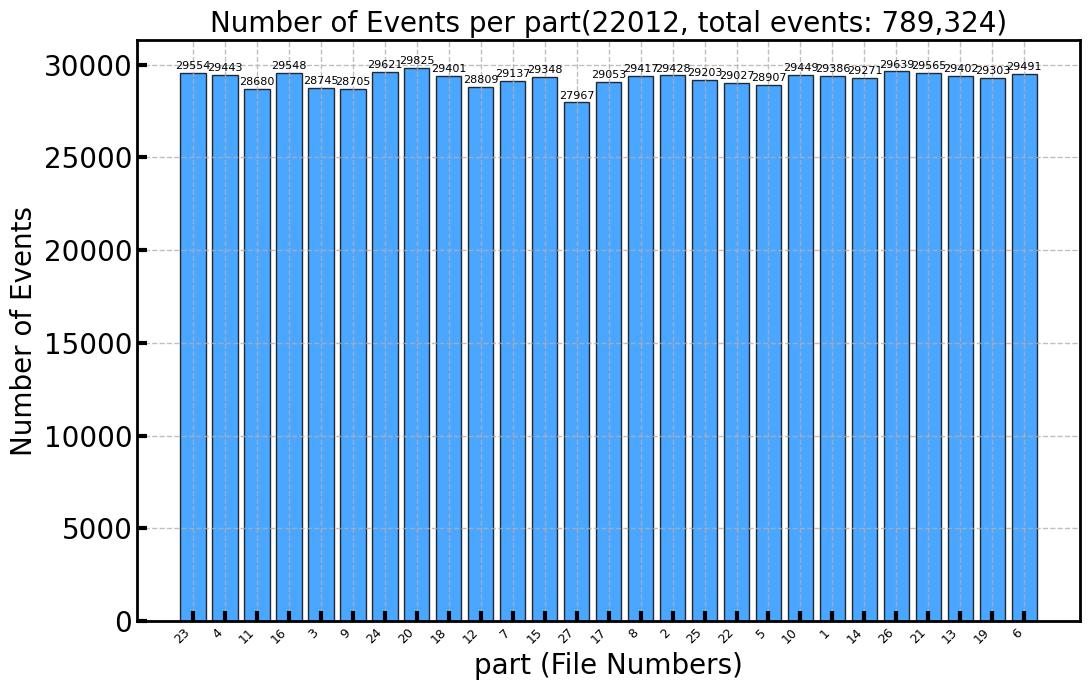

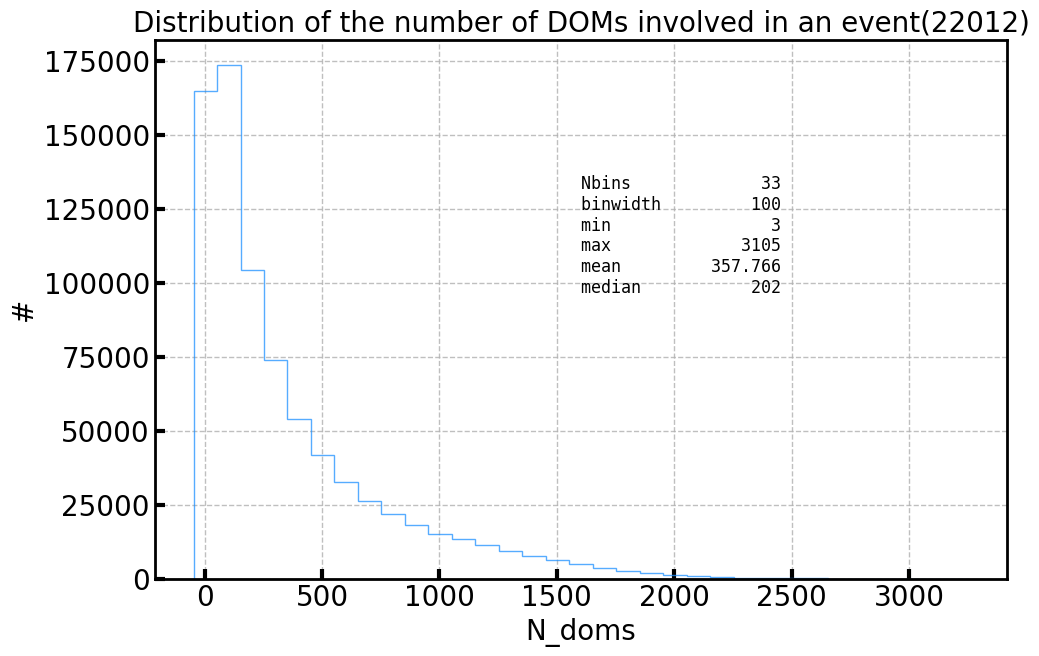

=========== Subdir 22012 Dataset Stat ===========
Number of parts: 27
Total events (rows in truth files across all parts): 789,324


In [37]:
dataset_NuMu_PeV_whole = PMTfiedDataset(NuMu_PeV_root, verbosity = 1, isPlot = True)

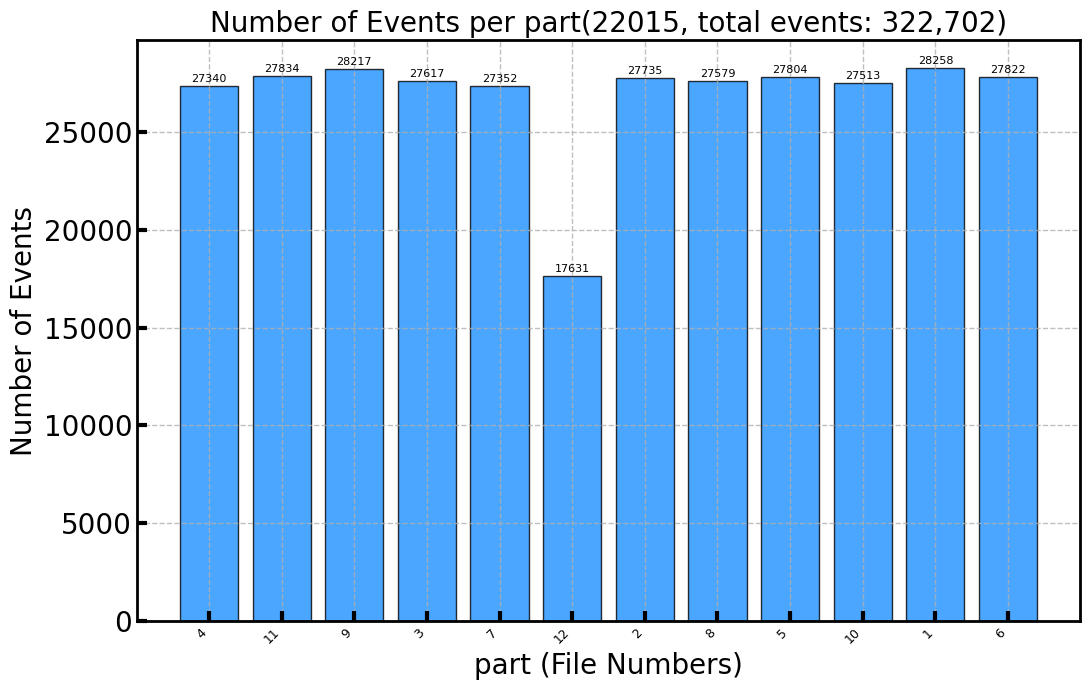

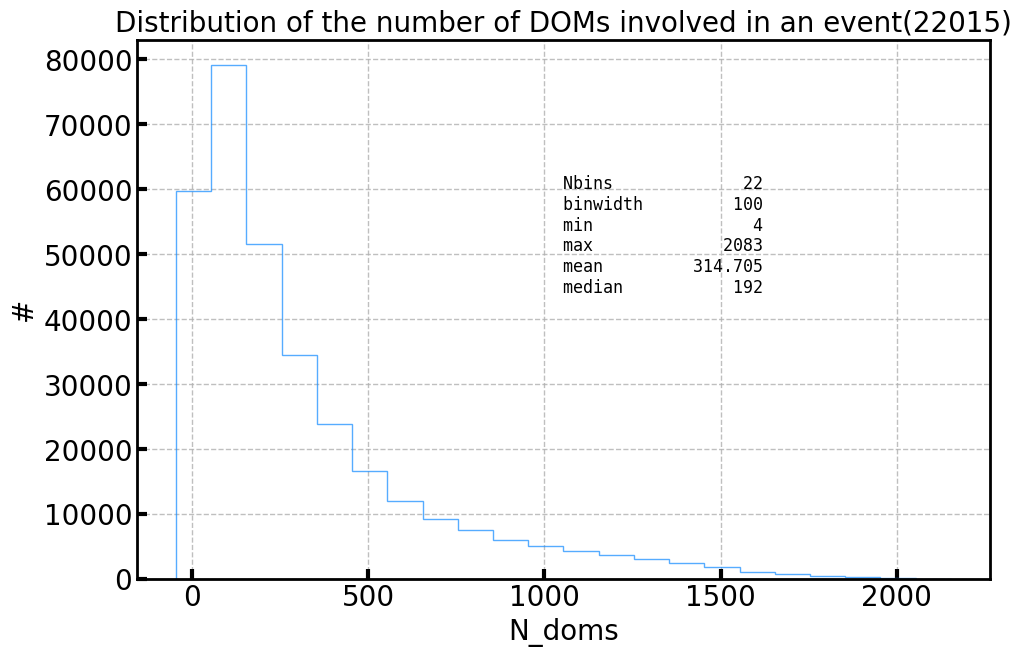

=========== Subdir 22015 Dataset Stat ===========
Number of parts: 12
Total events (rows in truth files across all parts): 322,702


In [38]:
dataset_NuE_PeV_whole = PMTfiedDataset(NuE_PeV_root, verbosity = 1, isPlot = True)

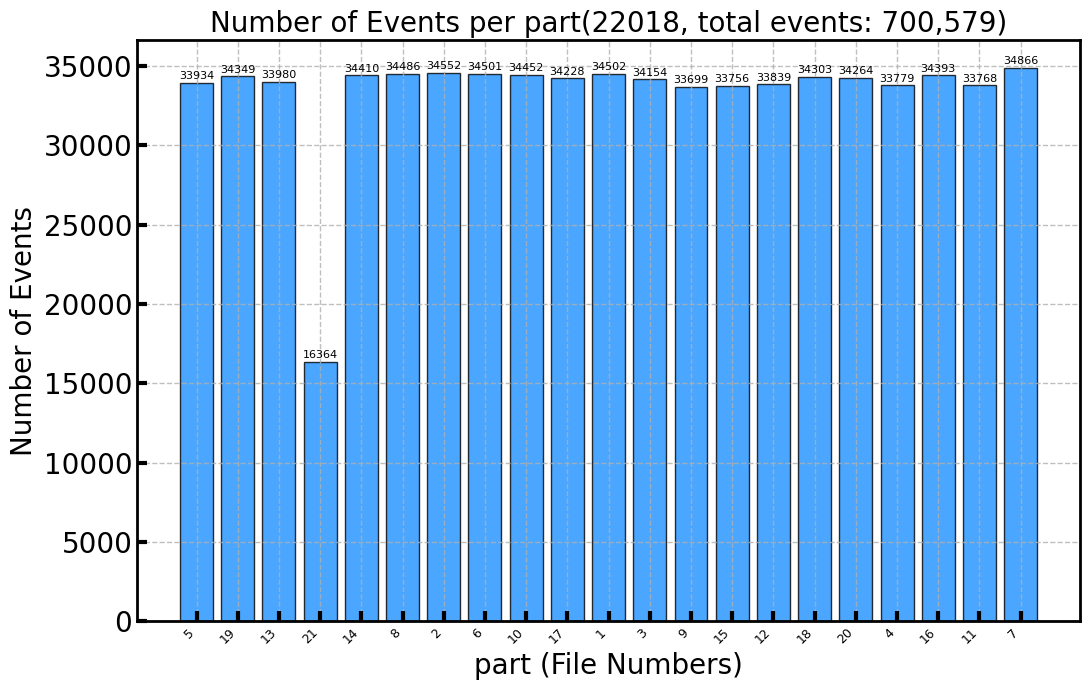

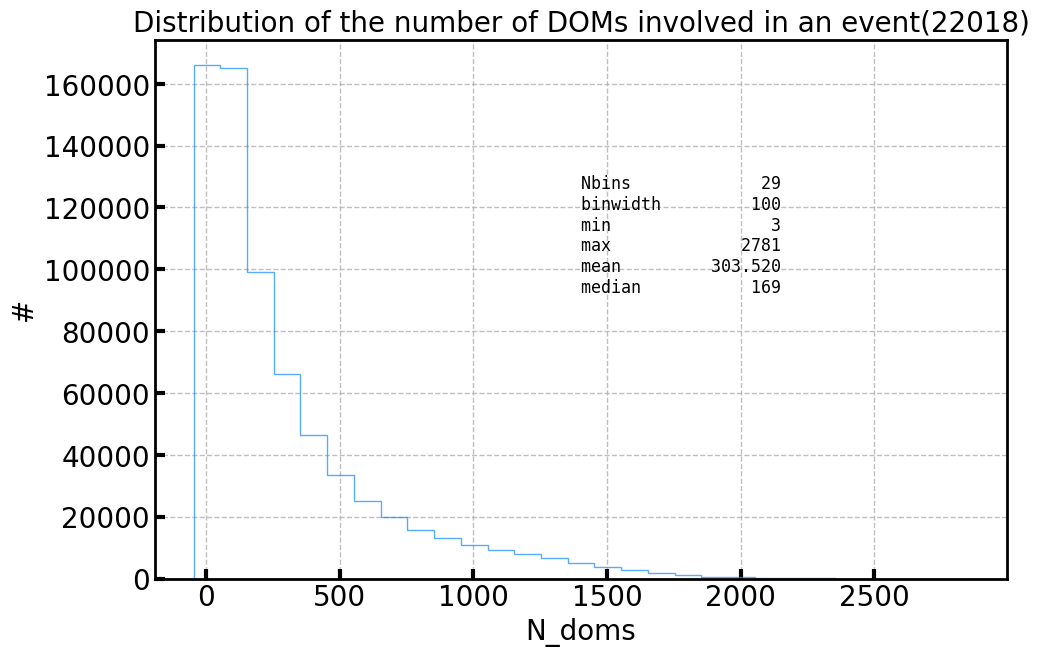

=========== Subdir 22018 Dataset Stat ===========
Number of parts: 21
Total events (rows in truth files across all parts): 700,579


In [39]:
dataset_NuTau_PeV_whole = PMTfiedDataset(NuTau_PeV_root, verbosity = 1, isPlot = True)

In [171]:
class PMTfiedDataModule(LightningDataModule):
    def __init__(
        self,
        root_subdir: str,
        isUseSinglePart: bool = False,
        batch_size: int = 32,
        num_workers: int = 4,
        verbosity: int = 0,
        part: str = None,
    ):
        super().__init__()
        self.root_subdir = root_subdir
        self.isUseSinglePart = isUseSinglePart
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.verbosity = verbosity
        self.part = part
        self.max_n_doms = None

    def setup(self, stage = None):
        if self.isUseSinglePart:
            print("Using PMTfiedDataset_part...")
            self.full_dataset = PMTfiedDataset_part(
                root_subdir=self.root_subdir,
                part=self.part,
                verbosity=self.verbosity
            )
            self.max_n_doms = self.full_dataset.get_N_dom_max()
        else:
            print("Using PMTfiedDataset...")
            self.full_dataset = PMTfiedDataset(
                root_subdir=self.root_subdir,
                verbosity=self.verbosity
            )
            self.max_n_doms = self.full_dataset.get_N_dom_max()

        train_size = int(0.8 * len(self.full_dataset))
        val_size = int(0.1 * len(self.full_dataset))
        test_size = len(self.full_dataset) - train_size - val_size

        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            self.full_dataset, [train_size, val_size, test_size], generator=generator
        )
    def _collate_fn(self, batch):
        features = [item["features"] for item in batch]
        truth = [item["truth"] for item in batch]
        mask = [item["mask"] for item in batch]
        
        features = torch.stack(features)
        truth = torch.stack(truth)
        mask = torch.stack(mask)

        return {
            "features": features,
            "truth": truth,
            "mask": mask,
        }
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            collate_fn=self._collate_fn,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self._collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self._collate_fn,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            collate_fn=self._collate_fn,
        )


I will tell more about the data. the PMTfied data has the features that I will feed the model. and one of the columns is 'event_no' which the truth data also has. I may want to do these: regression on columns: 'azimuth', 'zenith', or 'energy' or multiclass classification for 'pid'.

'azimuth', 'zenith', 'energy' and 'pid' are all columns of truth data

## Multi-head Attention with ALiBi 
$\boxed{\text{input layer}} \rightarrow \boxed{\text{query, key, value projections}} \rightarrow \boxed{\text{scaled dot-product attention}} \rightarrow \boxed{\text{ALiBi bias addition}} \rightarrow \boxed{\text{attention scores}} \rightarrow \boxed{\text{weighted output}} \rightarrow \boxed{\text{output layer}}$

$$
\text{batch\_size, } d_{\text{model}} \text{, and } N_{\text{head}} \text{ are pre-defined by model builder, thus, so is } d_{\text{head}} = \frac{d_{\text{model}}}{N_{\text{head}}}
$$

$$
(\text{embed\_dim  is } d_{\text{model}}) 
$$

$$
\text{similarity measure } s_{ij} = q_i \cdot k_j^T 
$$

$$
\text{attention score } S_{ij} = \frac{s_{ij}}{\sqrt{d_k}} + m_l \cdot (j-i) + \text{mask}_{ij} \in \mathbb{R}^{\text{batch\_size} \times N_{\text{head}} \times N_{\text{dom}} \times N_{\text{dom}}}
$$

$$
\text{softmax }(S_{ij}) = \frac{\exp(S_{ij})}{\sum_{j=1}^{N_{\text{dom}}} \exp(S_{ij})} 
$$

$$
\text{attention}_i = \text{softmax}(S_{ij}) \cdot v_j \in \mathbb{R}^{\text{batch\_size} \times N_{\text{dom}} \times N_{\text{head}} \times d_{\text{head}}}
$$

* `nn.Linear` works for input tensor $x$, already containing both the weight matrix and the bias term: $y = x\cdot W^T + b$

In [172]:
class ALiBiAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model # d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.scale = self.head_dim ** -0.5
        self.dropout = nn.Dropout(dropout)

        # a layer is a linear transformation
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    # forward is invoked when calling the model
    # x is the input tensor
    # batch_size is the number of data samples in the batch
    # seq_length is the number of elements in the sequence(N_dom_max)
    # embed_dim is the dimension of the embedding
    def forward(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.size()
        # print(f"batch_size: {batch_size}, seq_length: {seq_length}, embed_dim: {embed_dim}")
        # print(f"embed_dim: {embed_dim}, d_model: {self.d_model}")
        assert embed_dim == self.d_model
        V = self.v_proj(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        attn_scores = self._get_attention_pure_score(x, batch_size, seq_length)
        alibi_bias = self._get_ALiBi_bias(x, seq_length)
        
        attn_scores += alibi_bias

        # Mask attention scores
        # masked_fill() fills elements of the tensor with a value where mask is True
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask[:, None, None, :] == 0, float("-inf"))

        attention = F.softmax(attn_scores, dim=-1)
        attn_output = torch.einsum("bhqk,bkhd->bqhd", attention, V).reshape(batch_size, seq_length, embed_dim)
        print(f"---------- attention ---------- ")
        print(f"attn_output has nan: {torch.isnan(attn_output).any()}")
        return self.out_proj(attn_output)
    
    def _get_attention_pure_score(self, x, batch_size, seq_length):
        Q = self.q_proj(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        K = self.k_proj(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        attn_scores = torch.einsum("bqhd,bkhd->bhqk", Q, K) * self.scale
        return attn_scores
    
    # HACK consider movig this outside this class. That would only be possible N_dom_max is constant for all parts...?
    def _get_ALiBi_bias(self, x, seq_length):
        # arange(n) returns a 1-D tensor of size n with values from 0 to n - 1
        slopes = 1.0 / (2 ** (torch.arange(self.num_heads).float() / self.num_heads))
        # to() moves the tensor to the device
        slopes = slopes.to(x.device)

        # view() reshapes the tensor
        relative_positions = torch.arange(seq_length).view(1, 1, seq_length) - torch.arange(seq_length).view(1, seq_length, 1)
        relative_positions = relative_positions.to(x.device)
        
        alibi_bias = slopes.view(self.num_heads, 1, 1) * relative_positions
        # unsqueeze() adds a dimension to the tensor
        alibi_bias = alibi_bias.unsqueeze(0)
        return alibi_bias

## Layer Normalisation $\boxed{\text{input layer}} \rightarrow \boxed{\text{normalised input layer}}$
$$
d_n \text{ is the dimension of the normalisation layer, here, } d_n = d_{\text{model}} = 
$$

$$
(\text{embed\_dim  is } d_n)
$$

$$
\mu^l = \frac{\sum_{i=1}^{d_n} x_i}{d_n}
$$

$$
\sigma^l = \sqrt{\frac{\sum_{i=1}^{d_n} (x_i - \mu^l)^2}{d_n}}
$$

$$
g_i^l, b_i^l \in \mathbb{R}^{d_n} : \text{learnable parameters}
$$

$$
\text{LayerNormalisation}_i(x) = g_i^l \cdot \frac{x_i - \mu^l}{\sigma^l} + b_i^l \text{  (of feature } i)
$$

In [173]:
class LayerNormalisation(nn.Module):
    def __init__(self, d_n, eps=1e-5):
        # d_n (int): dimension of the normalisation layer, 
        # here d_n = d_model = embed_dim
        super().__init__()
        self.d_n = d_n
        self.eps = eps

        self.g = nn.Parameter(torch.ones(d_n)) # gain
        self.b = nn.Parameter(torch.zeros(d_n)) # bias

    def forward(self, x):
        # (batch_size, seq_length, 1)
        mu = x.mean(dim=-1, keepdim=True)

        # (batch_size, seq_length, 1)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        x_normalised = (x - mu) / torch.sqrt(var + self.eps)

        # (batch_size, seq_length, d_n)
        x_tilde = self.g * x_normalised + self.b
        print(f"---------Layer Normalisation-----------")
        print(f"x has nan: {torch.isnan(x).any()}")
        print(f"mu has nan: {torch.isnan(mu).any()}")
        print(f"var has nan: {torch.isnan(var).any()}")
        print(f"x_normalised has nan: {torch.isnan(x_normalised).any()}")
        print(f"x_tilde has nan: {torch.isnan(x_tilde).any()}")
        
        return x_tilde

## Feed Forward Network $\boxed{\text{input layer}} \rightarrow \boxed{\text{hidden layer}} \rightarrow \boxed{\text{output layer}}$ 

$$
x_i^l \text{ is the input of the } i^{th} token in l^{th} \text{ layer}
$$

$$
d_{\text{f}} \text{ is the dimension of the feed forward network}
$$

$$
W_{h,i}^l, b_i^l \in \mathbb{R}^{d_{\text{model}} \times d_{\text{f}}} \text{ are learnable parameters}
$$

$$
\text{summed input } s_i^l = x_i^l W_{h,i}^l + b_{h,i}^l
$$

$$
\text{hidden layer } h_i^l = \text{ReLU}(s_i^l)
$$

$$
\text{summed output } x_i^{l+1} = h_i^l W_{f,i}^l + b_{f,i}^l
$$

In [174]:
class FFN(nn.Module):
    def __init__(self, d_model, d_f, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_f = d_f
        self.W_h = nn.Linear(d_model, d_f)
        self.W_f = nn.Linear(d_f, d_model)
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # (batch_size, seq_length, d_f)
        s_i = self.W_h(x)# summed input
        # (batch_size, seq_length, d_f)
        h_i = self.activation(s_i)
        h_i = self.dropout(h_i)
        
        # (batch_size, seq_length, d_model)
        x_next = self.W_f(h_i) # summed output
        
        print(f"---------FFN-----------")
        print(f"s_i has nan : {torch.isnan(s_i).any()}")
        print(f"h_i has nan : {torch.isnan(h_i).any()}")
        print(f"x_next has nan : {torch.isnan(x_next).any()}")
        return x_next

In [175]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_f, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_f = d_f
        self.dropout = nn.Dropout(dropout)
        
        self.attention = ALiBiAttention(d_model, n_heads, dropout)
        self.norm_attention = LayerNormalisation(d_model)
        
        self.ffn = FFN(d_model, d_f, dropout)
        self.norm_ffn = LayerNormalisation(d_model)
        
    def forward(self, x, mask=None):
        attn_output = self.attention(x, mask)
        x = self.norm_attention(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm_ffn(x + self.dropout(ffn_output))
        print (f"---------Encoder Block-----------")
        print(f"x has nan: {torch.isnan(x).any()}")
        return x

In [176]:
class TransformerModelPMT(LightningModule):
    def __init__(self, 
                d_model, 
                num_heads, 
                d_f, 
                num_layers, 
                d_input,
                dropout=0.1, 
                learning_rate=1e-4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_f = d_f
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        
        self.input_projection = nn.Linear(d_input, d_model)
        
        self.encoder_blocks = nn.ModuleList(
            [EncoderBlock(d_model, num_heads, d_f, dropout) for _ in range(num_layers)]
        )
        self.num_regression_targets = 1
        self.regression_output_layer = nn.Linear(d_model, self.num_regression_targets)

    def forward(self, x, mask=None):
        x = self.input_projection(x)
        for encoder in self.encoder_blocks:
            x = encoder(x, mask)
        x = self.regression_output_layer(x.mean(dim=1))
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x = batch["features"]
        y = batch["truth"]
        mask = batch["mask"]
        y_pred = self(x, mask)
        y_pred = y_pred.squeeze(-1)
        loss = F.mse_loss(y_pred, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch["features"]
        y = batch["truth"]
        mask = batch["mask"]
        print(f"x type = {type(x)}, shape = {x.shape}")
        print(f"mask type = {type(mask)}, shape = {mask.shape}")
        y_pred = self(x, mask)
        y_pred = y_pred.squeeze(-1)
        loss = F.mse_loss(y_pred, y)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x = batch["features"]
        y = batch["truth"]
        mask = batch["mask"]
        y_pred = self(x, mask).squeeze(-1)
        print(f" x has nan: {torch.isnan(x).any()}")
        print(f"mask has nan: {torch.isnan(mask).any()}")
        print(f"y_pred = {y_pred}")
        print(f"y = {y}")
        loss = F.mse_loss(y_pred, y)
        self.log("test_loss", loss, on_epoch=True, sync_dist=True)
        return loss

In [177]:
Sample_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/99999"
# NuMu_PeV_root

In [178]:
data_module_part = PMTfiedDataModule(
    root_subdir=Sample_root,
    isUseSinglePart=True,
    batch_size=8,
    num_workers=4,
    verbosity=1,
    part="98"
)

In [179]:
data_module_part.setup()

Using PMTfiedDataset_part...
 preparing feature files from /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/99999/98
------------- Part Dataset Statistics (part: 98) -------------
Total 74 events from 9 files
12 < N_doms/event < 1700 (avg: 400.19)


In [180]:
model = TransformerModelPMT(
    d_model=64,
    num_heads=4,
    d_f=128,
    num_layers=1,
    d_input=30, # number of features
    dropout=0.1,
    learning_rate=1e-4)

In [181]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):  # Check if the layer is Linear
#         nn.init.xavier_uniform_(m.weight)  # Xavier initialisation for weights
#         if m.bias is not None:
#             nn.init.zeros_(m.bias)  # Zero initialisation for biases

In [182]:
# model.apply(init_weights)

In [183]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="transformer-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min"
)
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=True,
    mode="min"
)
logger = TensorBoardLogger("logs", name="vanilla_sky")

In [184]:
trainer = Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=2,  # Use one GPU or CPU
    gradient_clip_val=1.0,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=1,  # Log metrics after every batch
    logger=logger
)

/groups/icecube/cyan/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /groups/icecube/cyan/.local/lib/python3.9/site-packa ...
GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


In [185]:
trainer.fit(model, datamodule=data_module_part)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

2024-12-02 10:30:10.283171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 10:30:10.326191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable

Using PMTfiedDataset_part...Using PMTfiedDataset_part...

 preparing feature files from /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/99999/98 preparing feature files from /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/99999/98

------------- Part Dataset Statistics (part: 98) -------------------------- Part Dataset Statistics (part: 98) -------------

Total 74 events from 9 filesTotal 74 events from 9 files

12 < N_doms/event < 1700 (avg: 400.19)12 < N_doms/event < 1700 (avg: 400.19)



/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /lustre/hpc/icecube/cyan/factory/IceCubeTransformer/checkpoints exists and is not empty.

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | input_projection        | Linear     | 2.0 K  | train
1 | encoder_blocks          | ModuleList | 33.5 K | train
2 | regression_output_layer | Linear     | 65     | train
---------------------------------------------------------------
35.5 K    Trainable params
0         Non-trainable params
35.5 K    Total params
0.142     Total estimated model params size (MB)

  | Name                    | Type       | Params | Mode 
---------------------------------------------------------------
0 | input_projection        | Linear     | 2.0 K  | train
1 | encoder_blocks          | ModuleList | 33.5 K | train
2 | regression_output_layer | Linear     | 65     |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/groups/icecube/cyan/.local/lib/python3.9/site-pac

x type = <class 'torch.Tensor'>, shape = torch.Size([4, 1700, 44])
mask type = <class 'torch.Tensor'>, shape = torch.Size([4, 1700])


/groups/icecube/cyan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]x type = <class 'torch.Tensor'>, shape = torch.Size([4, 1700, 44])
mask type = <class 'torch.Tensor'>, shape = torch.Size([4, 1700])


W1202 10:30:16.490540 140670663223104 torch/multiprocessing/spawn.py:146] Terminating process 1992724 via signal SIGTERM
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


ProcessRaisedException: 

-- Process 1 terminated with the following error:
Traceback (most recent call last):
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 76, in _wrap
    fn(i, *args)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 579, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 986, in _run
    results = self._run_stage()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1028, in _run_stage
    self._run_sanity_check()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1057, in _run_sanity_check
    val_loop.run()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py", line 182, in _decorator
    return loop_run(self, *args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/evaluation_loop.py", line 135, in run
    self._evaluation_step(batch, batch_idx, dataloader_idx, dataloader_iter)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/evaluation_loop.py", line 396, in _evaluation_step
    output = call._call_strategy_hook(trainer, hook_name, *step_args)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py", line 311, in _call_strategy_hook
    output = fn(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/strategies/strategy.py", line 410, in validation_step
    return self._forward_redirection(self.model, self.lightning_module, "validation_step", *args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/strategies/strategy.py", line 640, in __call__
    wrapper_output = wrapper_module(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/parallel/distributed.py", line 1636, in forward
    else self._run_ddp_forward(*inputs, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/parallel/distributed.py", line 1454, in _run_ddp_forward
    return self.module(*inputs, **kwargs)  # type: ignore[index]
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/strategies/strategy.py", line 633, in wrapped_forward
    out = method(*_args, **_kwargs)
  File "/tmp/ipykernel_1991132/2942737034.py", line 52, in validation_step
    y_pred = self(x, mask)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_1991132/2942737034.py", line 26, in forward
    x = self.input_projection(x)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/nn/modules/linear.py", line 117, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (6800x44 and 30x64)


In [ ]:
trainer.test(model, datamodule=data_module_part)

/groups/icecube/cyan/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /groups/icecube/cyan/.local/lib/python3.9/site-packa ...
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


/groups/icecube/cyan/.local/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /groups/icecube/cyan/.local/lib/python3.9/site-packa ...
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
distributed_backend=gloo
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

2024-11-30 15:16:5

Using PMTfiedDataset_part...Using PMTfiedDataset_part...

 preparing feature files from /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/99999/98 preparing feature files from /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied/Snowstorm/99999/98

------------- Part Dataset Statistics (part: 98) -------------------------- Part Dataset Statistics (part: 98) -------------

Total 74 events from 9 filesTotal 74 events from 9 files

12 < N_doms/event < 1700 (avg: 400.19)12 < N_doms/event < 1700 (avg: 400.19)



/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:215: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.


event_no: 199009800001435, shard_no: 98, offset: 2939, n_doms: 769
Available files: ['PMTfied_5.parquet', 'PMTfied_1.parquet', 'PMTfied_9.parquet', 'PMTfied_8.parquet', 'PMTfied_4.parquet', 'PMTfied_6.parquet', 'PMTfied_2.parquet', 'PMTfied_7.parquet', 'PMTfied_3.parquet']
Looking for file_key: PMTfied_98.parquet
Testing: |          | 0/? [00:00<?, ?it/s]event_no: 199009800001462, shard_no: 98, offset: 2544, n_doms: 759
Available files: ['PMTfied_5.parquet', 'PMTfied_1.parquet', 'PMTfied_9.parquet', 'PMTfied_8.parquet', 'PMTfied_4.parquet', 'PMTfied_6.parquet', 'PMTfied_2.parquet', 'PMTfied_7.parquet', 'PMTfied_3.parquet']
Looking for file_key: PMTfied_98.parquet


W1130 15:16:58.202313 140026722387776 torch/multiprocessing/spawn.py:146] Terminating process 1411333 via signal SIGTERM
[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15
Process ForkProcess-15:
Traceback (most recent call last):
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 76, in _wrap
    fn(i, *args)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 793, in _test_impl
    results = self._run(model, ckpt_path=ckpt_path)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 986, in _run
    results = self._run_stage()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.

ProcessRaisedException: 

-- Process 1 terminated with the following error:
Traceback (most recent call last):
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/multiprocessing/spawn.py", line 76, in _wrap
    fn(i, *args)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/strategies/launchers/multiprocessing.py", line 173, in _wrapping_function
    results = function(*args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 793, in _test_impl
    results = self._run(model, ckpt_path=ckpt_path)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 986, in _run
    results = self._run_stage()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py", line 1023, in _run_stage
    return self._evaluation_loop.run()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py", line 182, in _decorator
    return loop_run(self, *args, **kwargs)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/evaluation_loop.py", line 128, in run
    batch, batch_idx, dataloader_idx = next(data_fetcher)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/fetchers.py", line 133, in __next__
    batch = super().__next__()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/loops/fetchers.py", line 60, in __next__
    batch = next(self.iterator)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/combined_loader.py", line 341, in __next__
    out = next(self._iterator)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/combined_loader.py", line 142, in __next__
    out = next(self.iterators[0])
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1344, in _next_data
    return self._process_data(data)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1370, in _process_data
    data.reraise()
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/_utils.py", line 706, in reraise
    raise exception
FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/groups/icecube/cyan/.local/lib/python3.9/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/tmp/ipykernel_1311250/728362850.py", line 51, in __getitem__
    features = self._load_feature_rows(shard_no, offset, n_doms)
  File "/tmp/ipykernel_1311250/728362850.py", line 105, in _load_feature_rows
    raise FileNotFoundError(f"Feature file {file_key} not found in directory {self.part}.")
FileNotFoundError: Feature file PMTfied_98.parquet not found in directory 98.

